# Challenge: Validating a linear regression
Unit 2 / Lesson 5 / Project 2

### Validating regression models for prediction
Statistical tests are useful for making sure a model is a good fit to the test data, and that all the features are useful to the model.
However, to make sure a model has good predictive validity for new data, it is necessary to assess the performance of the model on new datasets.

The procedure is the same as what you learned in the Naive Bayes lesson – the holdout method and cross-validation method are both available.
You've already had experience writing code to run these kinds of validation models for Naive Bayes: now you can try it again with linear regression.

__In this case, your goal is to achieve a model with a consistent R2 and only statistically significant parameters across multiple samples.__

We'll use the property crime model you've been working on with, based on the FBI:UCR data.
Since your model formulation to date has used the entire New York State 2013 dataset, you'll need to validate it using some of the other crime datasets available at the FBI:UCR website.

Options include [other states crime rates in 2013](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table_8_offenses_known_to_law_enforcement_by_state_by_city_2013.xls/view) or [crime rates in New York State in other years](https://ucr.fbi.gov/crime-in-the-u.s/2014/crime-in-the-u.s.-2014/tables/table-8/table-8-by-state/Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls) or a combination of these.

### Iterate
Based on the results of your validation test, create a revised model, and then test both old and new models on a new holdout or set of folds.

Include your model(s) and a brief writeup of the reasoning behind the validation method you chose and the changes you made to submit and review with your mentor.

In [1]:
import math

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model

pd.options.display.float_format = '{:.3f}'.format

import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

%matplotlib inline
sns.set_style('white')

# suppress annoying harmless error
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')
warnings.filterwarnings("ignore",category =RuntimeWarning)

In [2]:
# load data
PATH1 = ('assets/ny_crime_data_2013.xls'
        )
PATH2 = ('assets/ny_crime_data_2014.xls'
        )
PATH3 = ('assets/cali_crime_data_2013.xls'
        )

# drop 'Rape\n(revised\ndefinition)1' column
ny_2013_raw = pd.read_excel(PATH1, header=4, skipfooter=3).drop(
    'Rape\n(revised\ndefinition)1', axis=1)
ny_2014_raw = pd.read_excel(PATH2, header=4, skipfooter=3).drop(
    'Rape\n(revised\ndefinition)1', axis=1)
ca_2013_raw = pd.read_excel(PATH1, header=4, skipfooter=3).drop(
    'Rape\n(revised\ndefinition)1', axis=1)

col_list = ['city', 'pop', 'violent_crime', 'murder', 'rape', 'robbery', 'assault',
           'property_crime', 'burglary', 'larceny', 'gta', 'arson']

# rename columns and fill NaN values with 0
for i in [ny_2013_raw, ny_2014_raw, ca_2013_raw]:
    i.columns = col_list
    i.fillna(value=0, axis=0, inplace=True)

ny_2013_raw.head()

,city,pop,violent_crime,murder,rape,robbery,assault,property_crime,burglary,larceny,gta,arson
0,Adams Village,1861,0,0,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0.000
2,Akron Village,2846,3,0,0,0,3,16,1,15,0,0.000
3,Albany,97956,791,8,30,227,526,4090,705,3243,142,0.000
4,Albion Village,6388,23,0,3,4,16,223,53,165,5,0.000


In [3]:
# create feature dataframes
ny13_features = ny_2013_raw.iloc[:,1:]
ny14_features = ny_2014_raw.iloc[:,1:] 
ca13_features = ca_2013_raw.iloc[:,1:] 

# convert continuous data into categorical
for i in [ny13_features, ny14_features, ca13_features]:
    for n in ['murder', 'rape', 'robbery', 'assault', 'burglary', 'larceny', 'gta', 'arson']:
        i[str(n)] = np.where(i[str(n)] >= 1, 1, 0)

# add 1 and perform log transformation on
# 'population' and 'property crime' features
for i in [ny13_features, ny14_features, ca13_features]:
    i['log_pop'] = np.log1p(i['pop']) 
    i['log_pcrime'] = np.log1p(i['property_crime'])

ny13_features.head()

,pop,violent_crime,murder,rape,robbery,assault,property_crime,burglary,larceny,gta,arson,log_pop,log_pcrime
0,1861,0,0,0,0,0,12,1,1,0,0,7.529,2.565
1,2577,3,0,0,0,1,24,1,1,1,0,7.855,3.219
2,2846,3,0,0,0,1,16,1,1,0,0,7.954,2.833
3,97956,791,1,1,1,1,4090,1,1,1,0,11.492,8.317
4,6388,23,0,1,1,1,223,1,1,1,0,8.762,5.412


In [4]:
# Instantiate and fit our model
regr = linear_model.LinearRegression()
Y = ny13_features['log_pcrime'].values.reshape(-1, 1)
X = ny13_features[['log_pop','murder','robbery']]
regr.fit(X, Y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[0.94054499 0.25780529 0.88702551]]

Intercept: 
 [-4.26034]

R-squared:
0.8017442686613627


### Measure model performance.

Now that we have our model... 
$$ log(Property Crime) = \alpha + log(Population) + Murder + Robbery$$

Let's verify that our parameters are all significant and perform a cross-validation test to determine the consistency of our $R^2$

In [5]:
# Write out the model formula.
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form
linear_formula = 'log_pcrime ~ log_pop+murder+robbery'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=ny13_features).fit()

display(lm.params, lm.pvalues, lm.rsquared, lm.conf_int())

Intercept   -4.260
log_pop      0.941
murder       0.258
robbery      0.887
dtype: float64

Intercept   0.000
log_pop     0.000
murder      0.057
robbery     0.000
dtype: float64

0.8017442686613627

,0,1
Intercept,-4.970,-3.551
log_pop,0.854,1.027
murder,-0.007,0.523
robbery,0.687,1.087


In [6]:
# cross validate our model
from sklearn.model_selection import train_test_split
from sklearn import linear_model

data = ny13_features[['log_pop','murder','robbery']]
target = ny13_features.log_pcrime

reg = linear_model.LinearRegression()
reg.fit(data, target)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, random_state=20)
print('20% Holdout: ' + str(reg.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(reg.fit(data, target).score(data, target)))

20% Holdout: 0.7924927380502749
Testing on Sample: 0.8017442686613627


It looks like all of our parameters `log(Population)`, `Murder` and `Robbery` are statistically significant to our model.
Though the `Murder` parameter is the least signifcant, so let's see if we can update our model and improve its performance.

Our cross-validation test produced consistent $R^2$ values within a range of `0.792` - `0.801`.

### Update our model

Let's create a new iteration of our model with updated parameters and see if we can improve its performance.

In [7]:
# Instantiate and fit our new model
regr = linear_model.LinearRegression()
Y = ny13_features['log_pcrime'].values.reshape(-1, 1)
X = ny13_features[['log_pop','murder','robbery', 'rape', 'assault', 'burglary',
                   'larceny', 'gta', 'arson']]
regr.fit(X, Y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[0.70932519 0.2670883  0.55215992 0.49046513 0.32189333 0.69560068
  1.72952349 0.2895029  0.20410819]]

Intercept: 
 [-5.04561881]

R-squared:
0.8789640993335986


### Compare new model performance.

Now we have our new model... 
$$ log(Property Crime) = \alpha + log(Population) + Murder + Robbery + Rape + Assault + Burglary + Larceny + Auto-vehicalTheft + Arson$$

Let's test our new parameters and our $R^2$

In [8]:
# Write out the model formula.
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form
linear_formula = 'log_pcrime ~ log_pop+murder+robbery+rape+assault+burglary+larceny+gta+arson'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=ny13_features).fit()

display(lm.params, lm.pvalues, lm.rsquared, lm.conf_int())

Intercept   -5.046
log_pop      0.709
murder       0.267
robbery      0.552
rape         0.490
assault      0.322
burglary     0.696
larceny      1.730
gta          0.290
arson        0.204
dtype: float64

Intercept   0.000
log_pop     0.000
murder      0.014
robbery     0.000
rape        0.000
assault     0.001
burglary    0.000
larceny     0.000
gta         0.001
arson       0.030
dtype: float64

0.8789640993335988

,0,1
Intercept,-5.748,-4.343
log_pop,0.632,0.787
murder,0.054,0.480
robbery,0.383,0.722
rape,0.330,0.650
assault,0.129,0.514
burglary,0.373,1.018
larceny,1.212,2.247
gta,0.117,0.462
arson,0.020,0.388


Right away, looking at our $P-values$ it looks like we can drop `Arson`, as it doesn't meet our threshold of `< 0.05`.

Looking at our parameters, it looks like `log(Population)`, `larceny`, `burglary`, `robbery` and `rape` are have the greatest affect on `property crimes`.
This is not surprising, as `property crimes` is a composite of `larceny`, `burglary`, `robbery` and `auto-vehical theft`.

Let's make sure these values aren't exhibiting any correlation before we proceed.

,log_pop,murder,robbery,rape,assault,burglary,larceny,gta
log_pop,1.000,0.503,0.582,0.554,0.425,0.359,0.212,0.483
murder,0.503,1.000,0.313,0.381,0.196,0.103,0.058,0.226
robbery,0.582,0.313,1.000,0.471,0.429,0.286,0.176,0.449
rape,0.554,0.381,0.471,1.000,0.302,0.213,0.120,0.283
assault,0.425,0.196,0.429,0.302,1.000,0.339,0.296,0.404
burglary,0.359,0.103,0.286,0.213,0.339,1.000,0.479,0.338
larceny,0.212,0.058,0.176,0.120,0.296,0.479,1.000,0.237
gta,0.483,0.226,0.449,0.283,0.404,0.338,0.237,1.000


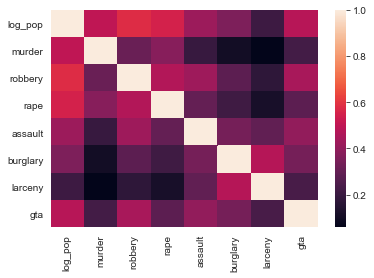

In [9]:
#check for correlation
X = ny13_features[['log_pop','murder','robbery', 'rape', 'assault', 'burglary',
                   'larceny', 'gta']]
correlation_matrix = X.corr()
display(correlation_matrix)
sns.heatmap(X.corr());

It looks like these some slight correlation between `robbery` and `log(Population)`, but not enough to be concerned about.

Let's test our parameters and $R^2$ again and perform a cross-validation test on our new model.

In [10]:
# Write out the new model formula
linear_formula = 'log_pcrime ~ log_pop+murder+robbery+rape+assault+burglary+larceny+gta'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=ny13_features).fit()

display(lm.params, lm.pvalues, lm.rsquared, lm.conf_int())

Intercept   -5.101
log_pop      0.717
murder       0.283
robbery      0.551
rape         0.511
assault      0.341
burglary     0.679
larceny      1.730
gta          0.294
dtype: float64

Intercept   0.000
log_pop     0.000
murder      0.010
robbery     0.000
rape        0.000
assault     0.001
burglary    0.000
larceny     0.000
gta         0.001
dtype: float64

0.877265014687678

,0,1
Intercept,-5.806,-4.397
log_pop,0.640,0.795
murder,0.069,0.496
robbery,0.381,0.722
rape,0.352,0.671
assault,0.148,0.534
burglary,0.355,1.002
larceny,1.210,2.251
gta,0.120,0.467


Now we can see `murder` has $P-value$ too high to be included in our model.
Let's drop that and run our model again.

In [11]:
# Write out the new model formula
linear_formula = 'log_pcrime ~ log_pop+robbery+rape+assault+burglary+larceny+gta'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=ny13_features).fit()

display(lm.params, lm.pvalues, lm.rsquared, lm.conf_int())

Intercept   -5.351
log_pop      0.753
robbery      0.554
rape         0.541
assault      0.338
burglary     0.645
larceny      1.721
gta          0.293
dtype: float64

Intercept   0.000
log_pop     0.000
robbery     0.000
rape        0.000
assault     0.001
burglary    0.000
larceny     0.000
gta         0.001
dtype: float64

0.8748089340590908

,0,1
Intercept,-6.035,-4.667
log_pop,0.680,0.826
robbery,0.382,0.726
rape,0.382,0.701
assault,0.143,0.532
burglary,0.320,0.970
larceny,1.196,2.246
gta,0.118,0.468


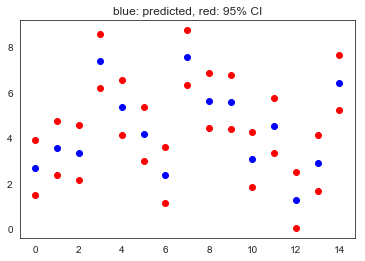

In [12]:
prstd, iv_l, iv_u = wls_prediction_std(lm)

plt.figure()
plt.plot(iv_u[0:15], 'o', color='r')
plt.plot(iv_l[0:15], 'o', color='r')
plt.plot(lm.fittedvalues[0:15], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()

All our parameters look good, our $R^2$ looks good, and all our variables are statistically signifcant.
Let's proceed with cross-validation our new model.

In [13]:
# cross validate our model
# we already imported train_test_split and linear_model
# from sklearn

data = ny13_features[['log_pop', 'robbery', 'rape', 'assault', 'burglary', 'larceny', 'gta']]
target = ny13_features.log_pcrime

reg = linear_model.LinearRegression()
reg.fit(data, target)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, random_state=20)
print('20% Holdout: ' + str(reg.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(reg.fit(data, target).score(data, target)))

20% Holdout: 0.8685225597726475
Testing on Sample: 0.8748089340590908


Our $R^2$ values are consistent withing a range of `0.868` - `0.874`.
This looks like a strong enough model to continue.

### cross validate model with other state data
Now that we have a consistent and statistically significant model, let's use it to analyze similar crime data from another state to compare performance.

We'll use crime data again from 2013, but this time from California instead of New York state.

In [14]:
# Instantiate and fit our model to California data
regr = linear_model.LinearRegression()
Y = ca13_features['log_pcrime'].values.reshape(-1, 1)
X = ca13_features[['log_pop','robbery', 'rape', 'assault', 'burglary',
                   'larceny', 'gta', 'arson']]
regr.fit(X, Y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[0.74240388 0.55475881 0.51682683 0.3172345  0.66472933 1.72041419
  0.28824719 0.21941791]]

Intercept: 
 [-5.27648977]

R-squared:
0.8767811036437985


In [15]:
# Write out the new model formula
linear_formula = 'log_pcrime ~ log_pop+robbery+rape+assault+burglary+larceny+gta'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=ca13_features).fit()

display(lm.params, lm.pvalues, lm.rsquared, lm.conf_int())

Intercept   -5.351
log_pop      0.753
robbery      0.554
rape         0.541
assault      0.338
burglary     0.645
larceny      1.721
gta          0.293
dtype: float64

Intercept   0.000
log_pop     0.000
robbery     0.000
rape        0.000
assault     0.001
burglary    0.000
larceny     0.000
gta         0.001
dtype: float64

0.8748089340590908

,0,1
Intercept,-6.035,-4.667
log_pop,0.680,0.826
robbery,0.382,0.726
rape,0.382,0.701
assault,0.143,0.532
burglary,0.320,0.970
larceny,1.196,2.246
gta,0.118,0.468


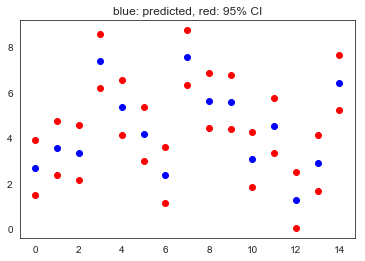

In [16]:
prstd, iv_l, iv_u = wls_prediction_std(lm)

plt.figure()
plt.plot(iv_u[0:15], 'o', color='r')
plt.plot(iv_l[0:15], 'o', color='r')
plt.plot(lm.fittedvalues[0:15], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()

,log_pop,robbery,rape,assault,burglary,larceny,gta,arson
log_pop,1.000,0.582,0.554,0.425,0.359,0.212,0.483,0.285
robbery,0.582,1.000,0.471,0.429,0.286,0.176,0.449,0.204
rape,0.554,0.471,1.000,0.302,0.213,0.120,0.283,0.268
assault,0.425,0.429,0.302,1.000,0.339,0.296,0.404,0.207
burglary,0.359,0.286,0.213,0.339,1.000,0.479,0.338,0.075
larceny,0.212,0.176,0.120,0.296,0.479,1.000,0.237,0.061
gta,0.483,0.449,0.283,0.404,0.338,0.237,1.000,0.169
arson,0.285,0.204,0.268,0.207,0.075,0.061,0.169,1.000


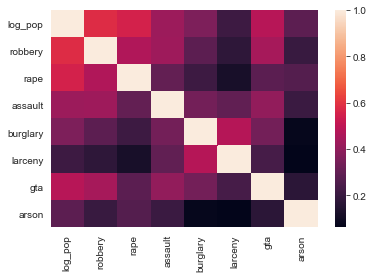

In [17]:
#check for correlation
correlation_matrix = X.corr()
display(correlation_matrix)
sns.heatmap(X.corr());

In [18]:
# cross validate our model
# we already imported train_test_split and linear_model
# from sklearn

data = ca13_features[['log_pop', 'robbery', 'rape', 'assault', 'burglary', 'larceny', 'gta']]
target = ca13_features.log_pcrime

reg = linear_model.LinearRegression()
reg.fit(data, target)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, random_state=20)
print('20% Holdout: ' + str(reg.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(reg.fit(data, target).score(data, target)))

20% Holdout: 0.8685225597726475
Testing on Sample: 0.8748089340590908


It looks like our model performed consistently across data from multiple states.
Here is our final linear formula...
$$ log(Property Crime) = \alpha + log(Population) + Robbery + Rape + Assault + Burglary + Larceny + Auto-vehical Theft$$